In [443]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Readme
Change dataset, crop_id, obj_id only

# 1. Crop images

In [444]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model)

In [445]:
def move_to_device(segmentor_model, device="cuda:0"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

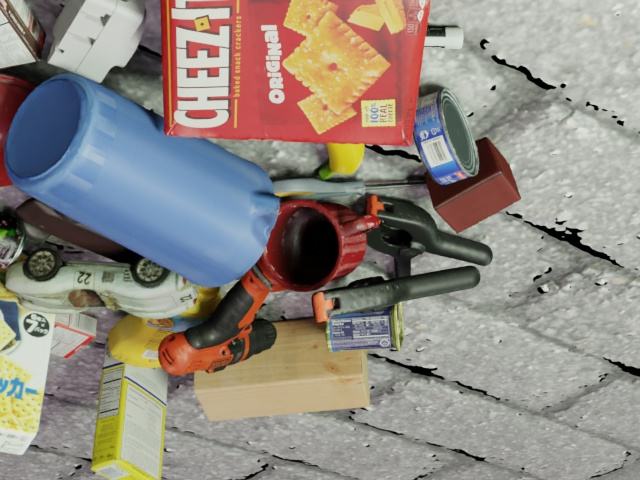

In [481]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "ycbv"
rgb_path = f"datasets/bop23_challenge/datasets/{dataset}/train_pbr/000003/rgb/000001.jpg"
rgb = Image.open(rgb_path).convert("RGB").rotate(180)
detections = custom_sam_model.generate_masks(np.array(rgb))
rgb

In [482]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

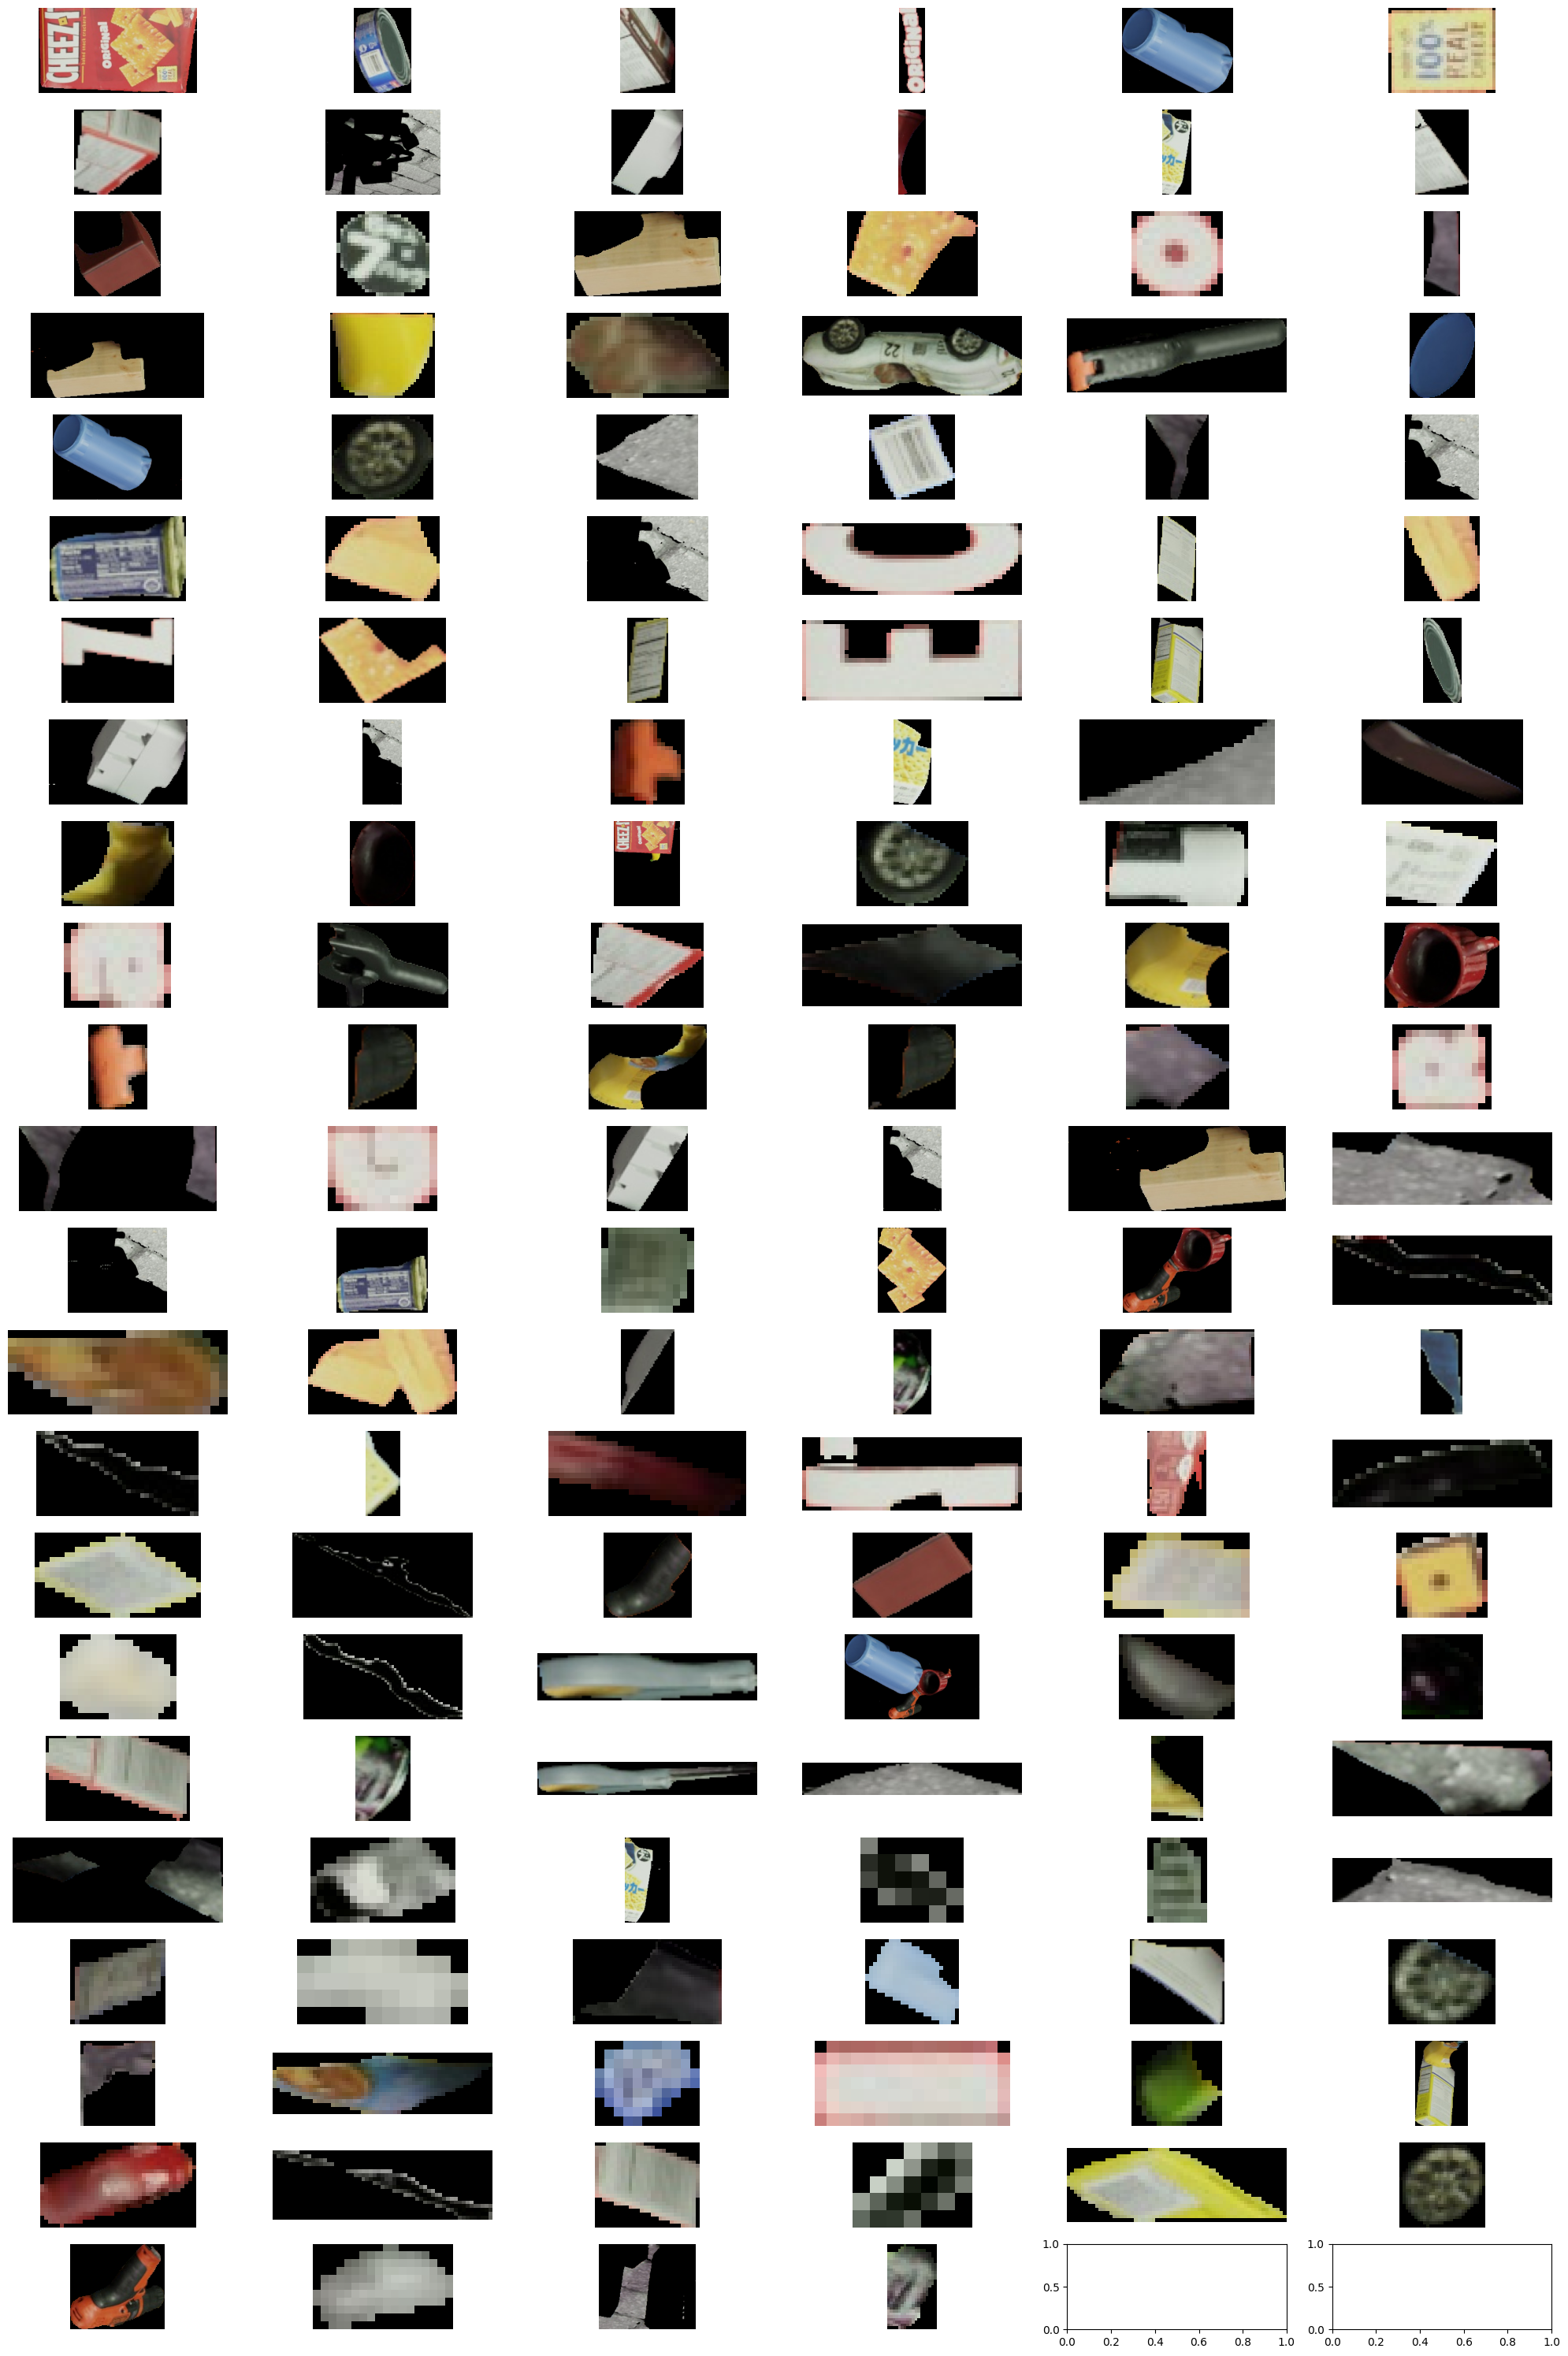

In [483]:
# Visualize proposals
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6
# Plot the masked_images array in a grid
plot_images(masked_images, rows, cols) 

In [484]:
import os

# Choose crop 4 it is in object id 12
crop_idx = 0
obj_id = 2
crop1 = {
    "crop" : masked_images[crop_idx], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : detections["masks"][crop_idx],
    "boxes" : detections["boxes"][crop_idx]
}
# save image
if not os.path.exists(f"foundpose_analysis/{dataset}"):
    os.makedirs(f"foundpose_analysis/{dataset}")
crop1["crop"].save(f"foundpose_analysis/{dataset}/crop1.png")

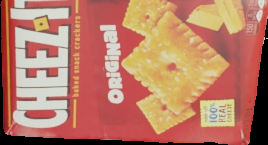

In [485]:
crop1["crop"]

# 2. Templates

## 2.1 Create templates of object

In [486]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
# initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

In [487]:
import os
import glob

default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{dataset}"
ref_dataloader_config.template_dir = " "

level_template = 1 # Level 0 :42 templates, level 1, 162 templates
ref_dataloader_config.level_templates = level_template 
ref_dataloader_config.split = "test"

ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/models/*.ply")
obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
ref_dataloader_config.obj_ids = obj_ids

out_folder = f"foundpose_analysis/{dataset}/templates"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
ref_dataloader_config.out_dir = out_folder
ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"

In [488]:
import os
os.environ['HYDRA_FULL_ERROR'] = '1'

In [489]:
from hydra.utils import instantiate
ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
ref_dataset.load_processed_metaData(reset_metaData=True)

Loading metaData: 100%|██████████| 10/10 [00:00<00:00, 188.95it/s]
Finding nearest rendering close to template poses: 0it [00:00, ?it/s]


In [490]:
# from torchvision.utils import save_image
# import pandas as pd

# templates = pd.read_csv(f"{out_folder}/train_pbr_processed_metaData.csv")

# # Save templates as images
# for ob_id in range(1,len(obj_ids)+1): 
#     obj_id_path = os.path.join(f"{out_folder}/synthetic_images_templates/{dataset}/train_pbr", f'obj_{(ob_id):06d}') # The transformed templates - check line 244, 245 in bop_pbr.py
#     original_obj_id_path = os.path.join(f"{out_folder}/synthetic_images_templates/{dataset}/train_pbr", f'obj_{(ob_id):06d}_original')
    
#     if not os.path.exists(obj_id_path):
#         os.makedirs(obj_id_path)
#     if not os.path.exists(original_obj_id_path):
#         os.makedirs(original_obj_id_path)
        
#     for i, img in enumerate(ref_dataset[ob_id-1]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#         save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
#     for i, img in enumerate(ref_dataset[ob_id-1]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#         save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))

## 2.2. Patch descriptors register in 3D for templates

In [491]:
import glob
import os

# Load original templates when before putting through dinov2 we also apply transfomation.
template_path_1 = f"{out_folder}/synthetic_images_templates/{dataset}/train_pbr/obj_{obj_id:06d}" 
template_files_1= sorted(glob.glob(os.path.join(template_path_1, "*.png")), key=os.path.getmtime)

obj_id_2 = 3
template_path_2 = f"{out_folder}/synthetic_images_templates/{dataset}/train_pbr/obj_{obj_id_2:06d}" 
template_files_2 = sorted(glob.glob(os.path.join(template_path_2, "*.png")), key=os.path.getmtime)

obj_id_3 = 4
template_path_3 = f"{out_folder}/synthetic_images_templates/{dataset}/train_pbr/obj_{obj_id_3:06d}" 
template_files_3 = sorted(glob.glob(os.path.join(template_path_3, "*.png")), key=os.path.getmtime)

template_files = template_files_1
num_templates = len(template_files)
num_templates

642

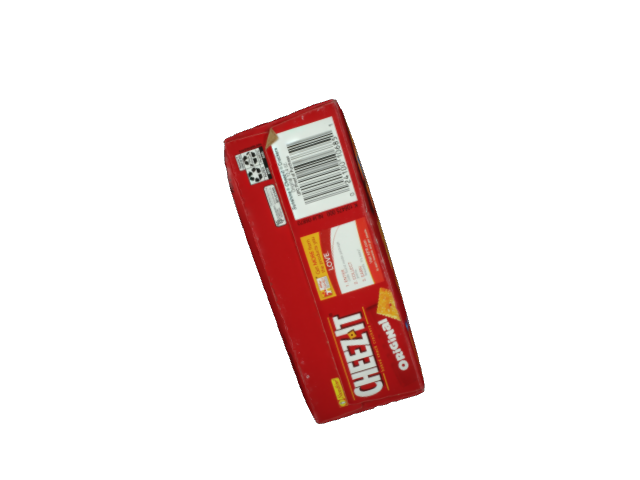

In [492]:
Image.open(template_files[2])

In [514]:
from PIL import Image
import numpy as np

templates = [np.array(Image.open(template_file).convert("RGB"))[50:450, 150:500, :3] for template_file in template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity

In [515]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_reg')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


normalized_templates shape torch.Size([3, 400, 350])
scaled_padded_templates.shape 642 torch.Size([3, 420, 420])


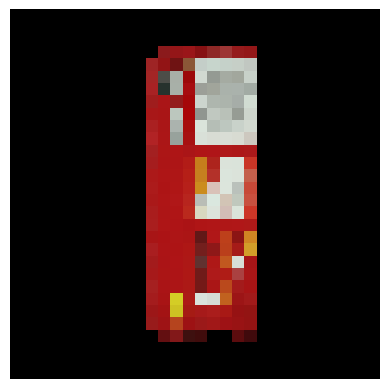

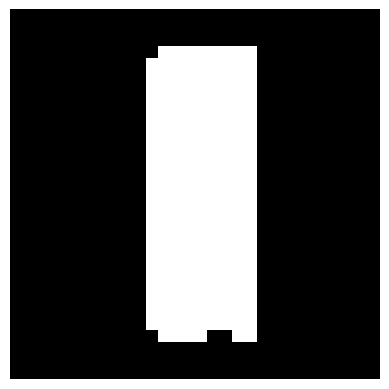

pca_crop_patches_descriptors.shape (221781, 256)


In [516]:
from src.model.foundpose import (
    crop_feature_extraction, 
    kmeans, 
    calculate_templates_labels, 
    calculate_templates_vector,
    calculate_crop_vector,
    calculate_similarity,
    templates_feature_extraction
)


pca_patches_descriptors, num_valid_patches = templates_feature_extraction(
    templates = templates, num_templates = num_templates, dino_model = dinov2_vitl14, device = device
    )

## 2.4 Perform Kmean clustering for all patch descriptors from templates (2048 clusters)

In [517]:
kmeans = kmeans(pca_patches_descriptors, ncentroids = 2048, niter = 20, verbose = True)

Clustering 221781 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (0.79 s, search 0.60 s): objective=4.78554e+07 imbalance=1.117 nsplit=0       


In [518]:
templates_labels = calculate_templates_labels(num_valid_patches, kmeans, pca_patches_descriptors)
templates_vector = calculate_templates_vector(templates_labels = templates_labels, num_clusters = 2048)

In [519]:
len(templates_labels)

642

# 3. BoW descriptor for rgb crop

In [520]:
# Load image crop 
crop_rgb = np.array(Image.open(f"foundpose_analysis/{dataset}/crop1.png").convert("RGB")) # (124, 157, 3)

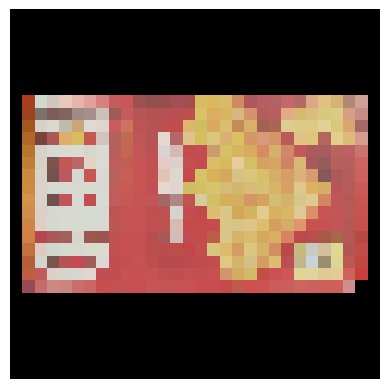

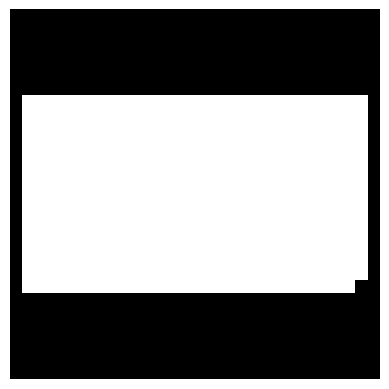

(445, 256)


In [521]:
pca_crop_patches_descriptors, num_valid_patches = crop_feature_extraction(crop_rgb = crop_rgb, dino_model = dinov2_vitl14, device = device)

In [522]:
# Assign labels to the data points
crop_labels = kmeans.index.search(pca_crop_patches_descriptors, 1)[1].reshape(-1)
crop_labels.shape

(445,)

In [523]:
crop_vector = calculate_crop_vector(crop_labels = crop_labels, templates_labels = templates_labels, num_clusters = 2048)
concat_templates_vector = torch.cat([torch.tensor(vector).view(1,-1) for vector in templates_vector]) # Goal torch.Size([642, 2048])

In [524]:
print(concat_templates_vector.shape)
print(crop_vector.shape)

torch.Size([642, 2048])
torch.Size([1, 2048])


In [525]:
concat_templates_vector

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0289, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

# 4. Retrieve top similar pose

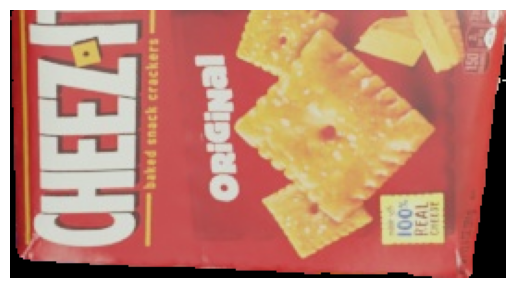

top 5 confidence scores tensor([[0.1306, 0.1251, 0.1250, 0.1202, 0.1195]], dtype=torch.float64)
final average confidence score tensor([0.1241], dtype=torch.float64)


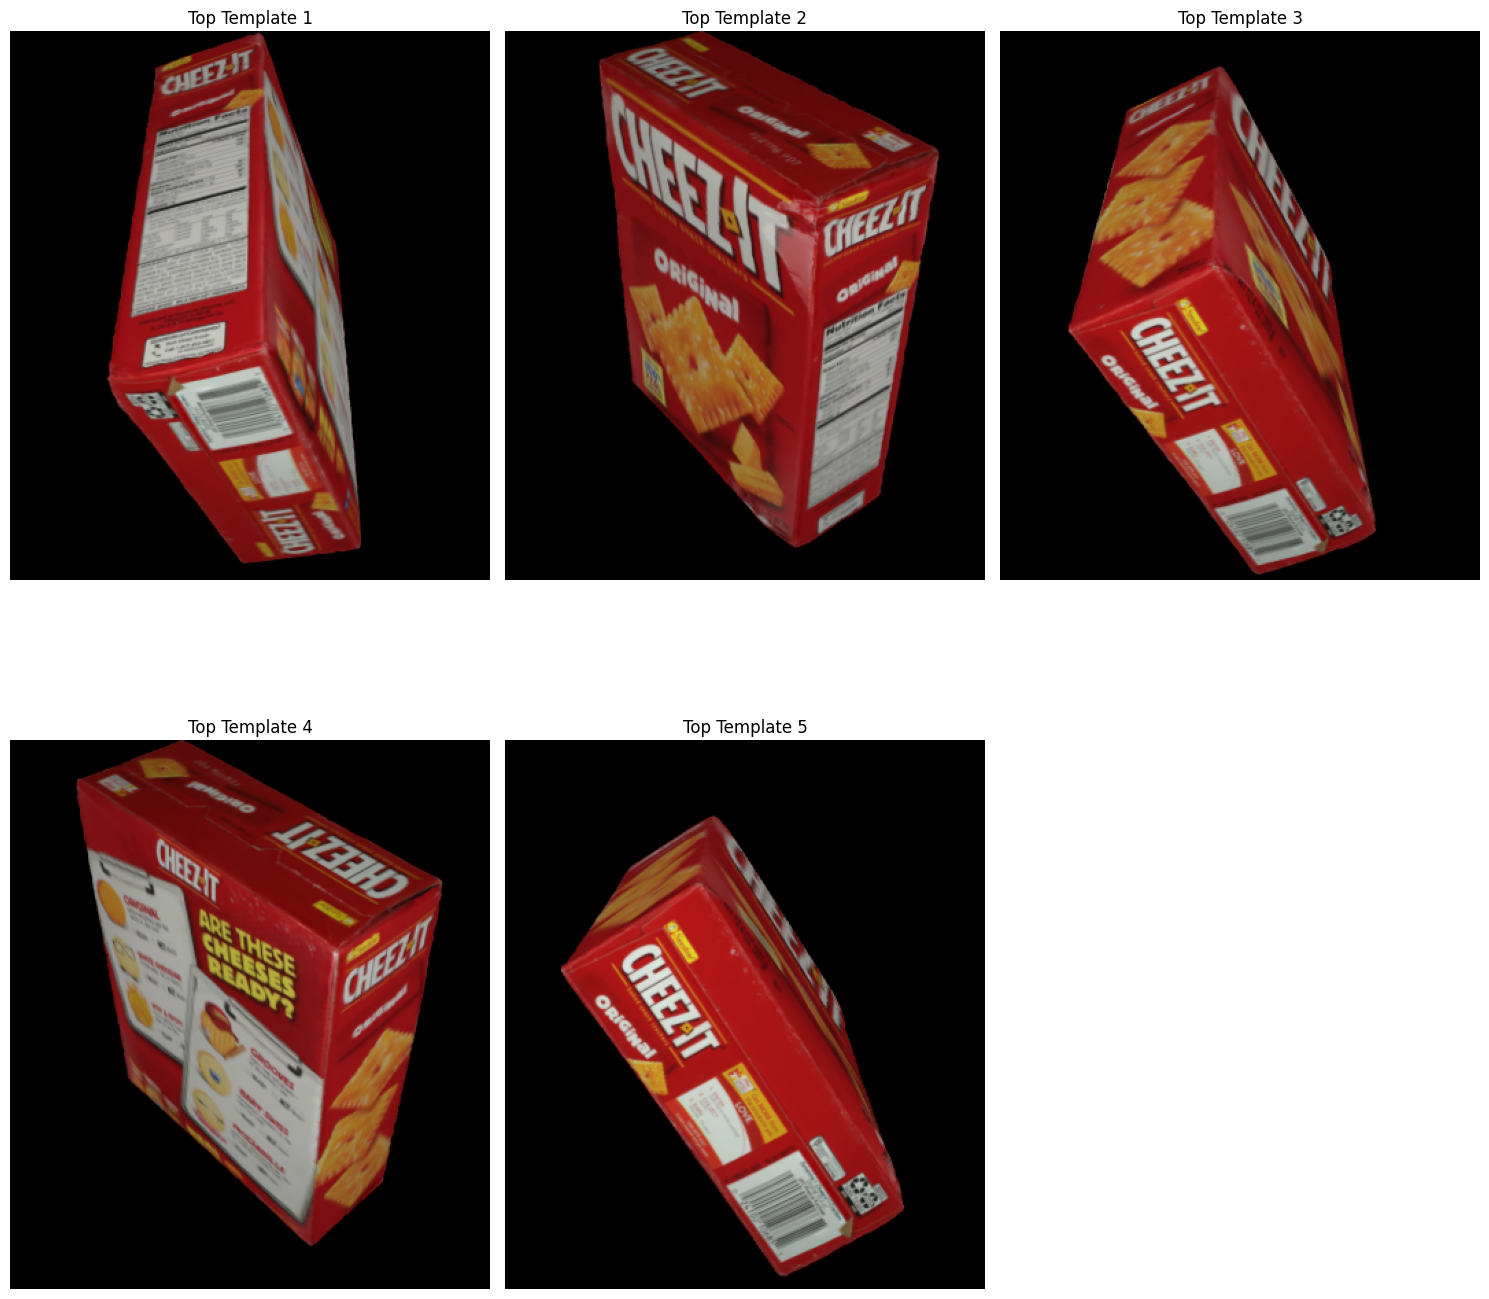

In [526]:
from src.model.foundpose import calculate_similarity
calculate_similarity(crop_rgb, crop_vector, concat_templates_vector, templates, synthetic=True)

# 5. Check extracted features
Compare input crop and template with similar pose that is picked manually. Check the cosine similarity


## 5.1 Check features using Cnos
Use dinov2 large model to cal the cosine similarity

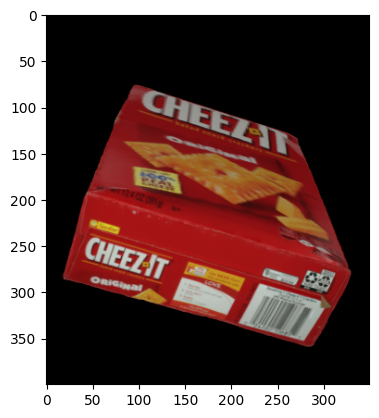

In [527]:
plt.imshow(templates[43])

In [528]:
print(torch.max(concat_templates_vector[43]))
print(torch.max(crop_vector))

tensor(0.0389, dtype=torch.float64)
tensor(0.0762, dtype=torch.float64)


In [529]:
print(concat_templates_vector[43].shape)
print(crop_vector.shape)

torch.Size([2048])
torch.Size([1, 2048])


In [530]:
import torch.nn.functional as F
query = crop_vector.clone()
reference = concat_templates_vector[43].unsqueeze(0).clone()
# query = F.normalize(query, dim=-1)
# reference = F.normalize(reference, dim=-1)
score = F.cosine_similarity(query, reference, dim=-1) # num_proposals, num_templates

In [531]:
score

tensor([0.0559], dtype=torch.float64)

### a. See la the score is so low that means the bow vector of the 2 are too different- which is wrong cos they look alike so the vecotr must be similar. It might be that the background of templates too big- change that, can crop that. to make the bachground smaller

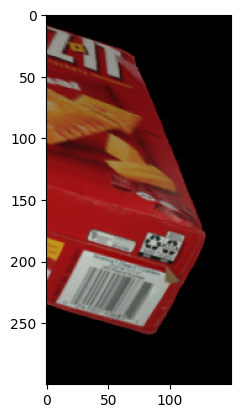

In [532]:
plt.imshow(templates[43][100:400, 200:450, :])

In [533]:
zoomed_in_template = templates[43][150:360, 220:420, :]

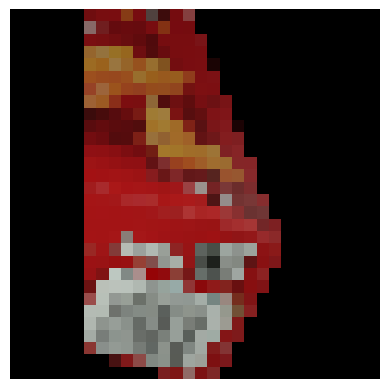

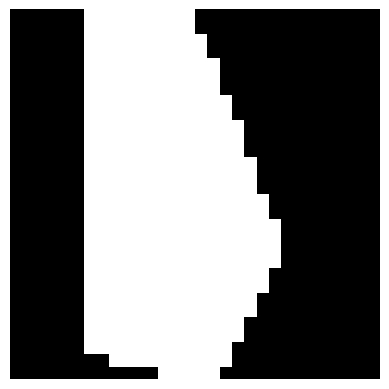

(378, 256)


In [534]:
pca_zoomed_in_template, num_valid_zoomed_in_template = crop_feature_extraction(crop_rgb = zoomed_in_template, dino_model = dinov2_vitl14, device = device)

In [535]:
# Assign labels to the data points
zoomed_in_template_labels = kmeans.index.search(pca_zoomed_in_template, 1)[1].reshape(-1)
zoomed_in_template_labels.shape

(378,)

In [536]:
zoomed_in_template_vector = calculate_crop_vector(crop_labels = zoomed_in_template_labels, templates_labels = templates_labels, num_clusters = 2048)

In [537]:
torch.max(zoomed_in_template_vector)

tensor(0.0521, dtype=torch.float64)

In [538]:
torch.max(zoomed_in_template_vector- concat_templates_vector[43])

tensor(0.0521, dtype=torch.float64)

In [539]:
import torch.nn.functional as F
query = crop_vector.clone()
reference = concat_templates_vector[43].unsqueeze(0).clone()
# query = F.normalize(query, dim=-1)
# reference = F.normalize(reference, dim=-1)
score = F.cosine_similarity(query, reference, dim=-1) # num_proposals, num_templates

In [540]:
cnos_dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
cnos_dinov2.patch_size = 14
if torch.cuda.is_available():
    cnos_dinov2 = torch.nn.DataParallel(cnos_dinov2).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [542]:
# nhap
indices = np.array(range(2562))
indices.save("src/poses/predefined_poses/idx_all_level3_in_level3.npy")

array([   0,    1,    2, ..., 2559, 2560, 2561])